In [1]:
import ML_ADMM_jpeg_corner_smoothing as mlcsc

In [2]:
import tensorflow as tf
import pickle as pkl
import jpeg_related_functions as jrf
import numpy as np

In [3]:
rho = 1.
noi = 32
alpha_init = 1.5
blkSmthCoef = 1.0
pklfile = 'ML_LRA_checkpoint_epoch_128.ckpt.pkl'
num_of_epochs = 1
#steps_per_epoch = 0

In [4]:
rho = 1.
noi = 32
alpha_init = 1.5
blkSmthCoef = 1.0
n_components = 4
cmplxdtype = tf.complex128 # This should really be elsewhere.
batch_size = 1
#steps_per_epoch = 4
step_size = 0.01
#num_of_epochs = 2

#   ******** BASE NAMES AND DIRECTORIES  ********
modelname = 'ML_ADMM_'
databasename = 'BSDS500/'
#databasename = 'simpleTest/'
experimentname = 'experiment1/'

#   ******** DEPENDENT NAMES AND DIRECTORIES
experimentpath = 'data/experiment/' + databasename + experimentname
checkpointfilename = modelname + 'checkpoint_epoch_{epoch:02d}.ckpt'
timesname = 'times/' + modelname + 'rho' + str(rho) + '_iter' + str(noi) + '_times.pkl'
modelfilename = modelname + 'initial_model.ckpt'

#   ******** DATA AND EXPERIMENT PARAMETERS ********
fid = open(experimentpath + 'problem_param.pckl','rb')
problem_param = pkl.load(fid)
fid.close()
data_param = problem_param['data_param']
targetSz = data_param['target_size']
qY = data_param['qY']
qUV = data_param['qUV']
strides = problem_param['stride']
fltrSz = problem_param['fltrSz']
real_dtype = data_param['dtype']
#noi = problem_param['noi']
noL = problem_param['noL']
noc = problem_param['noc']
datapath = problem_param['datapath']
trainfile = problem_param['trainfile']
valfile = problem_param['valfile']
padding = data_param['padding']
fid = open(experimentpath + pklfile,'rb')
mu_init = pkl.load(fid)
D = pkl.load(fid)
b_init = pkl.load(fid)
fid.close()

#   ******** CROPPING AND PADDING ********
cropAndMerge = mlcsc.CropPadObject(targetSz,strides,[np.asarray(ks) for ks in fltrSz],real_dtype,blkSz = (8,8))
paddingTuple = cropAndMerge.paddingTuple
fftSz = cropAndMerge.get_fft_size(targetSz,strides)
paddingDiff = ((padding[0][0] - paddingTuple[0][0],padding[0][1] - paddingTuple[0][1]),(padding[1][0] - paddingTuple[1][0],padding[1][1] -  paddingTuple[1][1]))
assert(paddingDiff[0][0] >= 0)
assert(paddingDiff[0][1] >= 0)
assert(paddingDiff[1][0] >= 0)
assert(paddingDiff[1][1] >= 0)
    
#   ******** SETUP LOADING TFRECORD ********
startr = paddingDiff[0][0]
startc = paddingDiff[1][0]
endr = targetSz[0] + padding[0][0] + padding[0][1] - paddingDiff[0][1]
endc = targetSz[1] + padding[1][0] + padding[1][1] - paddingDiff[1][1]
example_structure = {'highpass': tf.io.FixedLenFeature([], tf.string), 'lowpass': tf.io.FixedLenFeature([], tf.string), 'compressed': tf.io.FixedLenFeature([], tf.string),'raw': tf.io.FixedLenFeature([], tf.string)}

def restore_double(x):
    return tf.io.parse_tensor(x,real_dtype)

class RGB2Y(tf.keras.layers.Layer):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.rgb2yuv = jrf.RGB2YUV(dtype = self.dtype)
    def call(self,inputs):
        s_YUV = self.rgb2yuv(inputs)
        return s_YUV[slice(None),slice(None),slice(0,1)]

rgb2y = RGB2Y(dtype=real_dtype)

def _parse_image_function(example_proto):
    x = tf.io.parse_single_example(example_proto, example_structure)
    highpass = restore_double(x['highpass'])
    lowpass = restore_double(x['lowpass'])
    #return ((highpass[slice(startr,endr),slice(startc,endc),slice(None)],lowpass[slice(startr,endr),slice(startc,endc),slice(None)],restore_double(x['compressed'])),rgb2y(restore_double(x['raw'])))
    return ((highpass[slice(startr,endr),slice(startc,endc),slice(None)],lowpass[slice(startr,endr),slice(startc,endc),slice(None)],restore_double(x['compressed'])),restore_double(x['raw']))

raw_dataset = tf.data.TFRecordDataset([datapath + valfile])
dataset = raw_dataset.map(_parse_image_function)
dataset_batch = dataset.batch(batch_size)



In [5]:
print(D[0].shape)
print(D[1].shape)
print(problem_param['D'][0].shape)
print(problem_param['D'][1].shape)

(7, 7, 1, 48)
(5, 5, 48, 64)
(1, 7, 7, 1, 48)
(1, 5, 5, 48, 64)


In [6]:
#   ******** BUILD MODEL ********
CSC = mlcsc.MultiLayerCSC_JPEGY(rho,alpha_init,mu_init,b_init,blkSmthCoef,qY,cropAndMerge,fftSz,strides,[tf.expand_dims(D_temp,axis=0) for D_temp in D],n_components,noi,noL,cmplxdtype)


In [7]:
#CSC = mlcsc.MultiLayerCSC_JPEG(rho,alpha_init,mu_init,b_init,blkSmthCoef,qY,qUV,cropAndMerge,fftSz,strides,D,n_components,noi,noL,cmplxdtype)


In [8]:
highpassShape = (targetSz[0] + paddingTuple[0][0] + paddingTuple[0][1],targetSz[1] + paddingTuple[1][0] + paddingTuple[1][1],noc)
highpass = tf.keras.Input(shape=highpassShape,dtype=real_dtype)
lowpass = tf.keras.Input(shape = highpassShape,dtype = real_dtype)
compressed = tf.keras.Input(shape = (targetSz[0],targetSz[1],noc),dtype= real_dtype)
inputs = (highpass,lowpass,compressed)
reconstruction1,reconstruction2,itstats = CSC(inputs)
model = tf.keras.Model(inputs,reconstruction1)
model2 = tf.keras.Model(inputs,reconstruction2)
model.compile(optimizer = tf.keras.optimizers.SGD(step_size),loss = tf.keras.losses.MSE,run_eagerly=False)
model2.compile(optimizer = tf.keras.optimizers.SGD(step_size),loss = tf.keras.losses.MSE,run_eagerly=False)

In [9]:
rgb2jpeg_coef = jrf.RGB2JPEG_Coef(dtype=tf.float64)
jpeg_coef2rgb = jrf.JPEG_Coef2RGB(dtype=tf.float64)
y2jpeg_coef = jrf.Y2JPEG_Coef(dtype=tf.float64)
import util
clip_rgb = util.clip(a=0.,b=1.,dtype=tf.float64)

In [10]:
ii = 0
img_num = 0
for x,y in dataset_batch:
    if ii == img_num:
        jpeg_coef_raw = rgb2jpeg_coef(y)
        print(jpeg_coef_raw[0].shape)
        print(jpeg_coef_raw[1].shape)
        print(jpeg_coef_raw[2].shape)
        break

(1, 4, 4, 64)
(1, 2, 2, 64)
(1, 2, 2, 64)


In [365]:
ii = 0
img_num = 61
for x,y in dataset_batch:
    if ii == img_num:
        recon1,recon2,itstats = CSC(x)
        jpeg_coef_raw = rgb2jpeg_coef(y)
        YU_dsV_ds = jrf.threeChannelQuantize(jpeg_coef_raw,qY,qUV,Yoffset = None)
        #recon1_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(recon1),YU_dsV_ds[1],YU_dsV_ds[2]])) 
        #recon2_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(recon2),YU_dsV_ds[1],YU_dsV_ds[2]]))
        recon1_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(clip_rgb(recon1)),YU_dsV_ds[1],YU_dsV_ds[2]]))
        recon2_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(clip_rgb(recon2)),YU_dsV_ds[1],YU_dsV_ds[2]]))
        cmprssd_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(x[2]),YU_dsV_ds[1],YU_dsV_ds[2]]))
        lowpass_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(cropAndMerge.crop(x[1])),YU_dsV_ds[1],YU_dsV_ds[2]]))
        break
    ii += 1

In [366]:
print(tf.reduce_max(recon1))
print(tf.reduce_min(recon1))

tf.Tensor(0.4223802562525993, shape=(), dtype=float64)
tf.Tensor(0.019560694125297897, shape=(), dtype=float64)


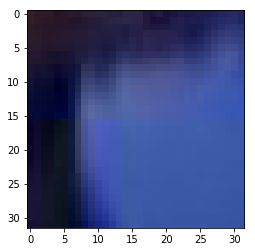

In [367]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np_img = np.asarray(tf.math.round(tf.squeeze(recon1_clr,axis=0)*255)).astype('uint8')
plt.imshow(np_img)
#print(np_img[7,7,0])
#print(np_img[7,8,0])
#print(np_img[8,7,0])
#print(np_img[8,8,0])

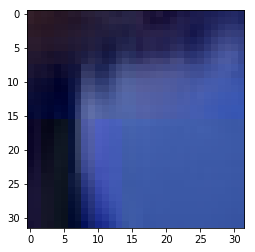

In [368]:
np_img2 = np.asarray(tf.math.round(tf.squeeze(recon2_clr,axis=0)*255)).astype('uint8')
plt.imshow(np_img2)

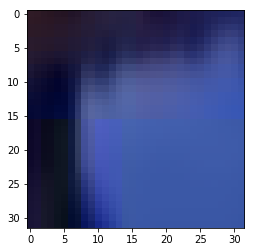

In [369]:
np_img_lp = np.asarray(tf.math.round(tf.squeeze(lowpass_clr,axis=0)*255)).astype('uint8')
plt.imshow(np_img_lp)

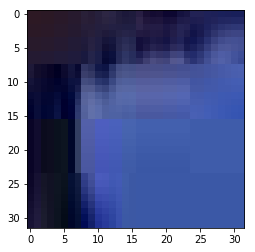

In [370]:
np_img_cmprssd = np.asarray(tf.math.round(tf.squeeze(cmprssd_clr,axis=0)*255)).astype('uint8')
plt.imshow(np_img_cmprssd)

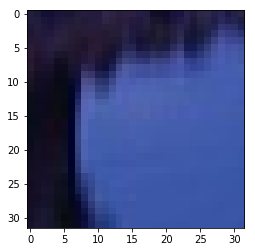

In [371]:
np_img_raw = np.asarray(tf.math.round(tf.squeeze(y,axis=0)*255)).astype('uint8')
plt.imshow(np_img_raw)

In [326]:
ii = 0
img_num = 64
for x,y in dataset_batch:
    if ii == img_num:
        #recon1,recon2,itstats = CSC(x)
        jpeg_coef_raw = rgb2jpeg_coef(y)
        YU_dsV_ds = jrf.threeChannelQuantize(jpeg_coef_raw,qY,qUV,Yoffset = None)
        #recon1_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(recon1),YU_dsV_ds[1],YU_dsV_ds[2]])) 
        #recon2_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(recon2),YU_dsV_ds[1],YU_dsV_ds[2]]))
        #recon1_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(clip_rgb(recon1)),YU_dsV_ds[1],YU_dsV_ds[2]]))
        #recon2_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(clip_rgb(recon2)),YU_dsV_ds[1],YU_dsV_ds[2]]))
        cmprssd_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(x[2]),YU_dsV_ds[1],YU_dsV_ds[2]]))
        lowpass_clr = clip_rgb(jpeg_coef2rgb([y2jpeg_coef(cropAndMerge.crop(x[1])),YU_dsV_ds[1],YU_dsV_ds[2]]))
        break
    ii += 1

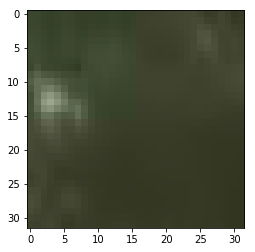

In [327]:
np_img_lp = np.asarray(tf.math.round(tf.squeeze(lowpass_clr,axis=0)*255)).astype('uint8')
plt.imshow(np_img_lp)

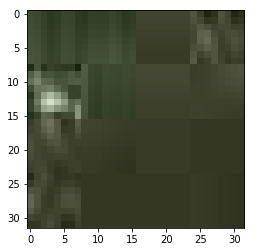

In [328]:
np_img_cmprssd = np.asarray(tf.math.round(tf.squeeze(cmprssd_clr,axis=0)*255)).astype('uint8')
plt.imshow(np_img_cmprssd)

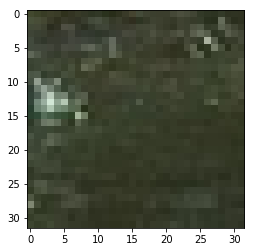

In [329]:
np_img_raw = np.asarray(tf.math.round(tf.squeeze(y,axis=0)*255)).astype('uint8')
plt.imshow(np_img_raw)